In [66]:
%matplotlib inline

import matplotlib.pyplot as plt
import cv2
import numpy as np
import requests
from toolz import pipe, flip, partial, curry

def load(url):
    return pipe(
        url,
        requests.get,
        flip(getattr, 'content'),
        bytearray,
        partial(np.asarray, dtype='uint8'),
        flip(cv2.imdecode, cv2.IMREAD_COLOR)
    )

original_image = load(f'https://api.mapbox.com/v4/mapbox.satellite/17/36850/51628@2x.png?access_token={TOKEN}')
image = cv2.imread('./tests/fixtures/sample_prediction.jpg') / 255

In [88]:
def find_contours(predicted_mask, tolerance):
    _, threshold = cv2.threshold(predicted_mask, 1 - tolerance, 1, cv2.THRESH_BINARY)
    gray = cv2.cvtColor(np.array(threshold, np.uint8), cv2.COLOR_BGR2GRAY)
    _, contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

@curry
def drawn_contours(original, predicted_mask, tolerance):
    marked = original.copy()
    cv2.drawContours(marked, find_contours(predicted_mask, tolerance), -1, (255,0,0), 3)
    return marked

In [89]:
from moviepy.editor import ImageSequenceClip

tolerances = map(lambda x: 1 - (x / 20), range(19))

contour_images = list(map(drawn_contours(original_image, image), tolerances))
clip = ImageSequenceClip(contour_images, fps=3)
clip.write_gif('./tests/fixtures/contour_animation.gif', fps=3, loop=True)


t:  16%|█▌        | 3/19 [00:00<00:00, 16.28it/s, now=None]

MoviePy - Building file ./tests/fixtures/contour_animation.gif with imageio.


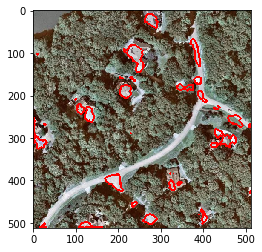

In [90]:
plt.imshow(drawn_contours(original_image, image, 0.5))
plt.show()

# Tiles to Coordinates

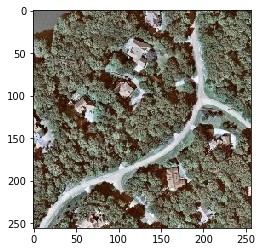

In [192]:
import mercantile
from geopy.geocoders import Nominatim
import shapely.geometry

def tile_for_address(address, zoom=16, user_agent='ABFS (Python)'):
    geolocator = Nominatim(user_agent=user_agent)

    location = geolocator.geocode(address)
    return mercantile.tile(location.longitude, location.latitude, zoom)

def image_for_tile(tile):
    return load(f'https://api.mapbox.com/v4/mapbox.satellite/{tile.z}/{tile.x}/{tile.y}.png?access_token={TOKEN}')

tile = tile_for_address('4728 Cypress Ford Drive', zoom=17)
tile_image = image_for_tile(tile)

plt.imshow(tile_image)
plt.show()

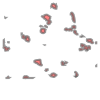

In [202]:
import json
from shapely.geometry import mapping
from toolz.curried import *

def xy_to_lng_lat(xy):
    lat_long = mercantile.lnglat(xy[0], xy[1])
    return (lat_long.lng, lat_long.lat)

@curry
def contour_to_lat_long(tile_image_size, tile, contour):
    xy_bounds = mercantile.xy_bounds(tile)
    height, width = tile_image_size
    width_scale = (xy_bounds.right - xy_bounds.left) / width
    height_scale = (xy_bounds.bottom - xy_bounds.top) / height
    xy_points = contour[:, :] * (width_scale, height_scale) + (xy_bounds.left, xy_bounds.top)
    
    if xy_points.shape[0] < 3:
        return None

    return shapely.geometry.Polygon(list(map(xy_to_lng_lat, xy_points[:, 0])))

def contours_to_multi_polygon(tile_image_size, tile, contours):
    return pipe(
        contours,
        map(contour_to_lat_long(tile_image_size, tile)),
        filter(lambda p: p is not None),
        list,
        shapely.geometry.MultiPolygon
    )

def multi_polygon_from_prediction(tile, prediction_image, tolerance):
    return contours_to_multi_polygon(
        prediction_image.shape[0:2],
        tile,
        find_contours(prediction_image, tolerance)
    )

multi_polygon_from_prediction(tile, image, 0.5)